In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix, n_component
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc, LOO_validation
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split
from gmr import GMM

In [3]:
data = pd.read_csv('daks_processed_with_rf.csv')
data

,Field name,Reservoir unit,Country,Region,Tectonic regime,Onshore/offshore,Hydrocarbon type,Productive area,Period,Depositional system,...,Netpay,Porosity,Permeability,Structural setting,Trapping mechanism,Depth,Oil density,Oil recovery factor,Condensate recovery factor,Gas recovery factor
0,A.J.BERMUDEZ,UNNAMED (CUNDUACAN FIELD),MEXICO,LATIN AMERICA,COMPRESSION,ONSHORE,OIL,NaN,CRETACEOUS,FORESLOPE,...,NaN,5.0,NaN,WRENCH,FOLD,3819.8,876.160991,0.33,NaN,NaN
1,A.J.BERMUDEZ,UNNAMED (SAMARIA FIELD),MEXICO,LATIN AMERICA,COMPRESSION,ONSHORE,OIL,24700.0,CRETACEOUS,FORESLOPE,...,NaN,8.0,NaN,WRENCH,FOLD,4120.1,876.160991,0.25,NaN,NaN
2,AB TEYMUR,ILAM,IRAN,MIDDLE EAST,COMPRESSION,ONSHORE,OIL,130910.0,CRETACEOUS,LOW-ENERGY CARBONATE MUD,...,70.1,12.0,NaN,FORELAND,FOLD,3063.1,904.153355,0.13,NaN,NaN
3,AB TEYMUR,SARVAK-1,IRAN,MIDDLE EAST,COMPRESSION,ONSHORE,OIL,133380.0,CRETACEOUS,LOW-ENERGY CARBONATE MUD,...,189.9,26.0,NaN,FORELAND,FOLD,3263.1,909.967846,0.13,NaN,NaN
4,ABKATUN,TAMABRA,MEXICO,LATIN AMERICA,COMPRESSION,OFFSHORE,OIL,58045.0,CRETACEOUS-PALEOGENE,FORESLOPE,...,NaN,9.0,3.1,SALT,FOLD,2920.7,887.147335,0.40,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,ПРИОБСКОЕ,Пласт: АС 10.0-1,RUSSIA,SIBERIA,NaN,ONSHORE,OIL,NaN,CRETACEOUS,DEEP MARINE,...,19.3,18.0,23.6,NaN,NaN,2487.0,880.800000,NaN,NaN,NaN
1108,ПРИОБСКОЕ,Пласт: АС 10.1-3,RUSSIA,SIBERIA,NaN,ONSHORE,OIL,NaN,CRETACEOUS,DEEP MARINE,...,18.2,18.6,32.7,NaN,NaN,2624.0,NaN,NaN,NaN,NaN
1109,ПРИОБСКОЕ,Пласт: АС 10.4,RUSSIA,SIBERIA,NaN,ONSHORE,OIL,NaN,CRETACEOUS,DEEP MARINE,...,12.9,17.5,33.4,NaN,NaN,2604.0,NaN,NaN,NaN,NaN
1110,ПРИОБСКОЕ,Пласт: АС 12.1,RUSSIA,SIBERIA,NaN,ONSHORE,OIL,NaN,CRETACEOUS,DEEP MARINE,...,21.0,17.7,28.7,NaN,NaN,2628.0,875.450000,NaN,NaN,NaN


In [4]:
t1=data['Oil density']
print("notnull:{}, null:{}".format(len(t1.dropna()), len(t1)-len(t1.dropna())))

notnull:994, null:118


In [5]:
t1=data['Oil recovery factor']
print("notnull:{}, null:{}".format(len(t1.dropna()), len(t1)-len(t1.dropna())))

notnull:705, null:407


In [6]:
t1=data['Condensate recovery factor']
print("notnull:{}, null:{}".format(len(t1.dropna()), len(t1)-len(t1.dropna())))

notnull:29, null:1083


In [7]:
t1=data['Gas recovery factor']
print("notnull:{}, null:{}".format(len(t1.dropna()), len(t1)-len(t1.dropna())))

notnull:212, null:900


In [8]:
data.columns

Index(['Field name', 'Reservoir unit', 'Country', 'Region', 'Tectonic regime',
       'Onshore/offshore', 'Hydrocarbon type', 'Productive area', 'Period',
       'Depositional system', 'Depositional environment', 'Lithology',
       'Porosity type', 'Gross', 'Netpay', 'Porosity', 'Permeability',
       'Structural setting', 'Trapping mechanism', 'Depth', 'Oil density',
       'Oil recovery factor', 'Condensate recovery factor',
       'Gas recovery factor'],
      dtype='object')

In [9]:
from pyrolite.util.time import Timescale
ts = Timescale()
import re

def conv_period3(period_input):
    period=re.split('/',period_input)
    temp=[]
    for iter2 in period:
        test1=iter2.split('-')
        for iter3 in test1:
            temp.append(ts.text2age(iter3))
    
    return(np.log(np.mean(temp)))
    #for elem in temp:
    #    if len(elem)==1:
    #        return(period_num_one.append(np.mean(elem)))
    #    else:
    #        return(np.mean([np.mean(elem) for i in elem]))
    
def conv_period_back3(period_input):
    return(ts.named_age(np.exp(period_input),level="Period"))
 

In [10]:
data['Period2']=data['Period']
data['Period2']=data['Period2'].apply(conv_period3)
data['Period3']=data['Period2']
data['Period3']=data['Period3'].apply(conv_period_back3)


In [46]:
data['Period2'][0:25]

0     4.658711
1     4.658711
2     4.658711
3     4.658711
4     4.317588
5     5.154158
6     5.154158
7     4.658711
8     4.658711
9     4.658711
10    2.549836
11    2.549836
12    2.549836
13    2.549836
14    3.355502
15    4.658711
16    4.658711
17    4.658711
18    4.658711
19    4.658711
20    4.658711
21    3.795826
22    3.795826
23    4.658711
24    6.141177
Name: Period2, dtype: float64

In [50]:
[i for i in geo['Period2'] if i==0]

[]

<AxesSubplot:>

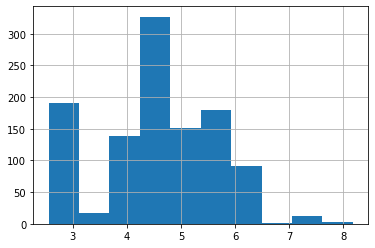

In [11]:
data['Period2'].hist()

In [12]:
data[['Period3','Period']][60:90]

,Period3,Period
60,Neogene,NEOGENE
61,Meso-proterozoic,PROTEROZOIC
62,Permian,PERMIAN
63,Permian,PERMIAN
64,Jurassic,JURASSIC
65,Permian,PERMIAN
66,Cretaceous,CRETACEOUS
67,Neogene,NEOGENE
68,Cretaceous,CRETACEOUS
69,Paleogene,PALEOGENE


In [13]:
columns = ['Tectonic regime', 'Period2', 'Lithology', 'Structural setting', 'Gross','Netpay','Porosity','Permeability', 'Depth', 'Oil density', 'Oil recovery factor']
geo=data.copy()
geo = geo[columns]
geo.dropna(inplace=True)
geo.reset_index(inplace=True, drop=True)

In [14]:
geo

,Tectonic regime,Period2,Lithology,Structural setting,Gross,Netpay,Porosity,Permeability,Depth,Oil density,Oil recovery factor
0,COMPRESSION,4.658711,LIMESTONE,SALT,76.2,30.5,21.0,60.0,1510.7,825.072886,0.26
1,GRAVITY,4.658711,LIMESTONE,PASSIVE MARGIN,29.0,4.6,12.0,20.0,2652.4,801.699717,0.34
2,EXTENSION,3.795826,THINLY-BEDDED SANDSTONE,RIFT,91.5,82.3,35.0,3500.0,1720.1,933.993399,0.36
3,STRIKE-SLIP,6.141177,DOLOMITE,INTRACRATONIC,182.9,122.0,4.0,10.0,1158.5,815.561960,0.48
4,COMPRESSION,5.795754,LIMESTONE,SUB-SALT,91.5,32.0,10.0,20.0,1829.3,876.160991,0.30
...,...,...,...,...,...,...,...,...,...,...,...
338,EXTENSION,3.795826,SANDSTONE,RIFT,50.0,18.9,23.2,121.0,1439.3,946.488294,0.13
339,EXTENSION,3.795826,SANDSTONE,RIFT,89.9,24.1,21.0,60.0,2310.7,881.619938,0.19
340,EXTENSION,5.068596,VOLCANICS,RIFT,150.0,59.1,12.7,3.6,3000.9,870.769231,0.05
341,COMPRESSION,5.795754,SANDSTONE,FORELAND,79.9,10.1,24.0,30.0,570.1,887.147335,0.24


In [36]:
geo[geo['Hydrocarbon type']=='GAS']

,Tectonic regime,Period,Lithology,Structural setting,Hydrocarbon type,Gross,Netpay,Porosity,Permeability,Depth,Oil density,Oil recovery factor
27,GRAVITY,NEOGENE,SANDSTONE,SALT,GAS,36.0,30.5,27.0,836.0,4222.6,832.352941,0.55
43,INVERSION,NEOGENE,THINLY-BEDDED SANDSTONE,INVERSION,GAS,2500.0,118.9,25.0,1000.0,339.9,865.443425,0.29
200,EXTENSION,JURASSIC,SANDSTONE,RIFT,GAS,139.9,115.9,27.5,5625.0,1975.6,806.267806,0.16


In [15]:
data[(data['Hydrocarbon type']=='GAS')&(data['Oil recovery factor'].notnull())]

,Field name,Reservoir unit,Country,Region,Tectonic regime,Onshore/offshore,Hydrocarbon type,Productive area,Period,Depositional system,...,Permeability,Structural setting,Trapping mechanism,Depth,Oil density,Oil recovery factor,Condensate recovery factor,Gas recovery factor,Period2,Period3
94,BALDPATE,BIG SAND,USA,NORTH AMERICA,GRAVITY,OFFSHORE,GAS,3198.65,NEOGENE,DEEP MARINE,...,836.0,SALT,FOLD,4222.6,832.352941,0.55,NaN,0.69,2.549836,Neogene
169,BUNYU,TARAKAN-SANTUL-TABUL-BUNYU,INDONESIA,FAR EAST,INVERSION,ONSHORE,GAS,3705.00,NEOGENE,COASTAL,...,1000.0,INVERSION,FOLD,339.9,865.443425,0.29,NaN,0.75,2.549836,Neogene
216,CHOCOLATE BAYOU,FRIO,USA,NORTH AMERICA,GRAVITY,ONSHORE,GAS,29640.00,PALEOGENE,COASTAL,...,156.0,DELTA,FOLD,2656.4,773.224044,0.60,NaN,NaN,3.795826,Paleogene
418,HUGOTON-PANHANDLE,CHASE (PANHANDLE),USA,NORTH AMERICA,COMPRESSION,ONSHORE,GAS,5434000.00,PERMIAN,LOW-ENERGY CARBONATE MUD,...,NaN,FORELAND,FOLD,533.5,829.912023,0.24,NaN,NaN,5.618228,Permian
557,MADURA MDA,PACIRAN (MADURA LIMESTONE),INDONESIA,FAR EAST,INVERSION,OFFSHORE,GAS,NaN,NEOGENE,FORESLOPE,...,10.0,INVERSION,FOLD,779.3,NaN,0.30,NaN,0.80,2.549836,Neogene
559,MAHOGANY (TRINIDAD),UNNAMED,TRINIDAD AND TOBAGO,LATIN AMERICA,GRAVITY,OFFSHORE,GAS,21983.00,NEOGENE,COASTAL,...,2400.0,FORELAND,FOLD,1737.8,854.984894,0.30,NaN,0.83,2.549836,Neogene
611,MIDGARD,FANGST,NORWAY,EUROPE,EXTENSION,OFFSHORE,GAS,28652.00,JURASSIC,COASTAL,...,5625.0,RIFT,EROSIONAL,1975.6,806.267806,0.16,0.52,0.72,5.154158,Jurassic
648,NILAM,BAPIKPAPAN,INDONESIA,FAR EAST,INVERSION,OFFSHORE,GAS,NaN,NEOGENE,COASTAL,...,100.0,INVERSION,FOLD,1698.2,797.183099,0.35,NaN,0.67,2.549836,Neogene
828,SEELIGSON,FRIO,USA,NORTH AMERICA,GRAVITY,ONSHORE,GAS,61750.00,PALEOGENE,FLUVIAL,...,332.0,DELTA,FOLD,1219.5,820.289855,0.45,NaN,NaN,3.795826,Paleogene
908,TENGE,UNITS XIIIB-XXIII,KAZAKHSTAN,FORMER SOVIET UNION,INVERSION,ONSHORE,GAS,25441.00,JURASSIC,FLUVIAL,...,100.0,INVERSION,FOLD,1539.6,852.409639,0.29,NaN,0.86,5.154158,Jurassic


In [16]:
geo_types = get_nodes_type(geo)
geo_types

{'Tectonic regime': 'disc',
 'Period2': 'cont',
 'Lithology': 'disc',
 'Structural setting': 'disc',
 'Gross': 'cont',
 'Netpay': 'cont',
 'Porosity': 'cont',
 'Permeability': 'cont',
 'Depth': 'cont',
 'Oil density': 'cont',
 'Oil recovery factor': 'cont'}

In [17]:
geo_signs = get_nodes_sign(geo)
geo_signs

{'Period2': 'pos',
 'Gross': 'pos',
 'Netpay': 'pos',
 'Porosity': 'pos',
 'Permeability': 'pos',
 'Depth': 'pos',
 'Oil density': 'pos',
 'Oil recovery factor': 'pos'}

In [18]:
colums_for_code = []
columns_for_disc = []
for c in columns:
    if geo_types[c] == 'disc':
        colums_for_code.append(c)
    else:
        columns_for_disc.append(c)

In [19]:
colums_for_code

['Tectonic regime', 'Lithology', 'Structural setting']

In [20]:
columns_for_disc

['Period2',
 'Gross',
 'Netpay',
 'Porosity',
 'Permeability',
 'Depth',
 'Oil density',
 'Oil recovery factor']

In [24]:
for i in columns_for_disc:
    print(len(geo_discrete[i].value_counts()))

5
5
5
5
5
5
5
5


In [23]:
geo_coded, label_coder = code_categories(geo, 'label', colums_for_code)
geo_discrete, coder = discretization(geo_coded, 'equal_frequency', columns_for_disc)
geo_only_discrete, discrete_coder = discretization(geo, 'equal_frequency', columns_for_disc)

In [25]:
sample = geo.sample(10)
sample_d = geo_discrete.sample(10)
sample.reset_index(inplace=True, drop=True)
sample_d.reset_index(inplace=True, drop=True)

In [26]:
bn_full = structure_learning(geo_discrete, 'HC', geo_types, 'K2')
bn_full

  0%|          | 20/1000000 [00:03<44:58:41,  6.18it/s]


{'V': ['Tectonic regime',
  'Period2',
  'Lithology',
  'Structural setting',
  'Gross',
  'Netpay',
  'Porosity',
  'Permeability',
  'Depth',
  'Oil density',
  'Oil recovery factor'],
 'E': [['Tectonic regime', 'Netpay'],
  ['Period2', 'Porosity'],
  ['Period2', 'Netpay'],
  ['Period2', 'Depth'],
  ['Period2', 'Oil density'],
  ['Lithology', 'Period2'],
  ['Lithology', 'Permeability'],
  ['Lithology', 'Netpay'],
  ['Lithology', 'Depth'],
  ['Lithology', 'Structural setting'],
  ['Lithology', 'Oil density'],
  ['Structural setting', 'Tectonic regime'],
  ['Structural setting', 'Period2'],
  ['Structural setting', 'Netpay'],
  ['Structural setting', 'Oil density'],
  ['Netpay', 'Gross'],
  ['Porosity', 'Permeability'],
  ['Porosity', 'Depth'],
  ['Permeability', 'Oil recovery factor'],
  ['Permeability', 'Oil density']]}

In [27]:
draw_BN(bn_full,geo_types,'test')

In [28]:
params = parameter_learning(geo, geo_types, bn_full)
save_structure(bn_full, 'all_net')
skel = read_structure('all_net')
save_params(params, 'all_net_param')
params = read_params('all_net_param')
all_bn = HyBayesianNetwork(skel, params)

In [29]:
from bayesian.calculate_accuracy import LOO_validation

In [31]:
accuracy_dict, rmse_dict=LOO_validation(geo,geo_discrete)

  0%|          | 20/1000000 [00:02<40:41:33,  6.83it/s]


1


  0%|          | 20/1000000 [00:02<40:49:22,  6.80it/s]


16
16
16


  0%|          | 22/1000000 [00:05<68:25:10,  4.06it/s]


19


  0%|          | 20/1000000 [00:02<41:02:20,  6.77it/s]


25
25
25


  0%|          | 20/1000000 [00:02<40:53:03,  6.79it/s]


35


  0%|          | 20/1000000 [00:02<41:11:19,  6.74it/s]


45
45
45


  0%|          | 20/1000000 [00:02<35:51:59,  7.74it/s]


47
47


  0%|          | 20/1000000 [00:02<37:36:04,  7.39it/s]


51
51


  0%|          | 20/1000000 [00:03<47:28:00,  5.85it/s]


62
62
62


  0%|          | 20/1000000 [00:03<43:08:53,  6.44it/s]


85


  0%|          | 20/1000000 [00:02<40:58:52,  6.78it/s]


88
88
88


  0%|          | 20/1000000 [00:02<41:00:19,  6.77it/s]


91


  0%|          | 20/1000000 [00:02<37:44:06,  7.36it/s]


94
94
94


  0%|          | 20/1000000 [00:03<43:09:03,  6.44it/s]


115
115
115


  0%|          | 20/1000000 [00:03<41:40:09,  6.67it/s]


135


  0%|          | 20/1000000 [00:02<41:24:07,  6.71it/s]


137
137
137


  0%|          | 20/1000000 [00:03<43:20:11,  6.41it/s]


139
139
139


  0%|          | 20/1000000 [00:02<41:14:44,  6.73it/s]


144


  0%|          | 20/1000000 [00:02<39:09:48,  7.09it/s]


148
148
148


  0%|          | 20/1000000 [00:03<41:41:31,  6.66it/s]


152
152
152


  0%|          | 20/1000000 [00:03<44:49:41,  6.20it/s]


155


  0%|          | 22/1000000 [00:05<74:31:50,  3.73it/s] 


156


  0%|          | 22/1000000 [00:05<72:12:12,  3.85it/s]


161


  0%|          | 20/1000000 [00:02<41:15:54,  6.73it/s]


163
163
163


  0%|          | 20/1000000 [00:02<41:22:44,  6.71it/s]


174


  0%|          | 20/1000000 [00:03<41:44:50,  6.65it/s]


189


  0%|          | 20/1000000 [00:02<41:09:56,  6.75it/s]


192
192
192


  0%|          | 20/1000000 [00:02<41:28:14,  6.70it/s]


209


  0%|          | 20/1000000 [00:03<45:21:25,  6.12it/s]


212
212
212


  0%|          | 20/1000000 [00:02<41:06:23,  6.76it/s]


216
216
216


  0%|          | 20/1000000 [00:02<41:22:44,  6.71it/s]


229


  0%|          | 20/1000000 [00:02<41:12:04,  6.74it/s]


236
236
236


  0%|          | 6/1000000 [00:00<30:33:47,  9.09it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [32]:
accuracy_dict

{'Tectonic regime': 0.78, 'Lithology': 0.58, 'Structural setting': 0.27}

In [33]:
rmse_dict

{'Period2': 0.12,
 'Gross': 0.13,
 'Netpay': 0.16,
 'Porosity': 0.18,
 'Permeability': 0.11,
 'Depth': 0.27,
 'Oil density': 0.07,
 'Oil recovery factor': 0.19}

In [34]:
import bayesian.calculate_accuracy

In [36]:
from importlib import reload  

reload(bayesian.calculate_accuracy)

<module 'bayesian.calculate_accuracy' from '/home/pandr/grafolog/open_grapholog/bayesian-synthetic-generator/bayesian/calculate_accuracy.py'>

In [37]:
bayesian.calculate_accuracy.LOO_validation2()

<function bayesian.calculate_accuracy.LOO_validation2(initial_data: pandas.core.frame.DataFrame, data_for_strucure_learning: pandas.core.frame.DataFrame, search: str = 'HC', score: str = 'K2', normed: bool = True, col: list = ['Tectonic regime', 'Period']) -> Tuple[dict, dict, list, list]>

In [39]:
col=geo.columns.tolist()
col

['Tectonic regime',
 'Period2',
 'Lithology',
 'Structural setting',
 'Gross',
 'Netpay',
 'Porosity',
 'Permeability',
 'Depth',
 'Oil density',
 'Oil recovery factor']

In [40]:
ac,rm,real,pred=bayesian.calculate_accuracy.LOO_validation2(geo,geo_discrete,col=col)

  0%|          | 20/1000000 [00:02<40:35:13,  6.84it/s]


1


  0%|          | 20/1000000 [00:02<40:40:15,  6.83it/s]


16
16
16


  0%|          | 22/1000000 [00:05<72:29:59,  3.83it/s]


19


  0%|          | 20/1000000 [00:03<44:49:12,  6.20it/s]


25
25
25


  0%|          | 20/1000000 [00:02<40:45:37,  6.81it/s]


35


  0%|          | 20/1000000 [00:03<44:52:31,  6.19it/s]


45
45
45


  0%|          | 20/1000000 [00:02<39:58:26,  6.95it/s]


47
47


  0%|          | 20/1000000 [00:02<35:23:01,  7.85it/s]


51
51


  0%|          | 20/1000000 [00:02<41:24:57,  6.71it/s]


62
62
62


  0%|          | 20/1000000 [00:02<40:41:56,  6.83it/s]


85


  0%|          | 20/1000000 [00:03<46:31:45,  5.97it/s]


88
88
88


  0%|          | 20/1000000 [00:02<40:29:30,  6.86it/s]


91


  0%|          | 20/1000000 [00:03<45:32:29,  6.10it/s]


94
94
94


  0%|          | 20/1000000 [00:02<40:43:21,  6.82it/s]


115
115
115


  0%|          | 20/1000000 [00:02<40:49:07,  6.81it/s]


135


  0%|          | 20/1000000 [00:02<40:45:39,  6.81it/s]


137
137
137


  0%|          | 20/1000000 [00:02<40:47:10,  6.81it/s]


139
139
139


  0%|          | 20/1000000 [00:03<44:19:43,  6.27it/s]


144


  0%|          | 20/1000000 [00:03<44:44:49,  6.21it/s]


148
148
148


  0%|          | 20/1000000 [00:03<45:12:27,  6.14it/s]


152
152
152


  0%|          | 20/1000000 [00:02<41:04:30,  6.76it/s]


155


  0%|          | 22/1000000 [00:06<77:58:40,  3.56it/s] 


156


  0%|          | 22/1000000 [00:06<77:44:58,  3.57it/s]


161


  0%|          | 20/1000000 [00:02<40:38:59,  6.83it/s]


163
163
163


  0%|          | 20/1000000 [00:02<40:56:27,  6.78it/s]


174


  0%|          | 20/1000000 [00:02<41:17:17,  6.73it/s]


189


  0%|          | 20/1000000 [00:03<44:40:16,  6.22it/s]


192
192
192


  0%|          | 20/1000000 [00:02<40:59:12,  6.78it/s]


209


  0%|          | 20/1000000 [00:03<44:47:27,  6.20it/s]


212
212
212


  0%|          | 20/1000000 [00:02<40:37:04,  6.84it/s]


216
216
216


  0%|          | 20/1000000 [00:03<45:08:51,  6.15it/s]


229


  0%|          | 20/1000000 [00:03<44:41:36,  6.22it/s]


236
236
236


  0%|          | 22/1000000 [00:06<77:35:21,  3.58it/s]


244
244
244
244


  0%|          | 20/1000000 [00:03<45:03:46,  6.16it/s]


245
245
245


  0%|          | 22/1000000 [00:06<77:37:48,  3.58it/s]


247


  0%|          | 20/1000000 [00:03<44:43:20,  6.21it/s]


263


  0%|          | 20/1000000 [00:02<40:41:45,  6.83it/s]


267
267
267


  0%|          | 20/1000000 [00:03<44:43:53,  6.21it/s]


284


  0%|          | 20/1000000 [00:02<41:08:59,  6.75it/s]


290


  0%|          | 20/1000000 [00:02<40:35:02,  6.84it/s]


291
291
291


  0%|          | 20/1000000 [00:03<44:36:27,  6.23it/s]


294
294
294


  0%|          | 20/1000000 [00:02<40:51:46,  6.80it/s]


301
301
301


  0%|          | 20/1000000 [00:03<44:46:39,  6.20it/s]


305


  0%|          | 20/1000000 [00:02<40:16:21,  6.90it/s]


"['BASEMENT', 'RIFT']"
"['BASEMENT']"
"['EXTENSION', 'BASEMENT', 'RIFT']"
"['BASEMENT']"
"['BASEMENT']"
"['BASEMENT', 'RIFT']"


  0%|          | 20/1000000 [00:02<40:54:42,  6.79it/s]


326


  0%|          | 20/1000000 [00:03<45:06:49,  6.16it/s]


327


  0%|          | 20/1000000 [00:02<40:25:16,  6.87it/s]


"['SHALY SANDSTONE', 'FORELAND']"
"['SHALY SANDSTONE']"
"['COMPRESSION', 'SHALY SANDSTONE', 'FORELAND']"
"['SHALY SANDSTONE']"
"['SHALY SANDSTONE']"
"['SHALY SANDSTONE', 'FORELAND']"


  0%|          | 20/1000000 [00:02<41:04:44,  6.76it/s]


330


  0%|          | 20/1000000 [00:02<40:44:41,  6.82it/s]


"['VOLCANICS', 'RIFT']"
"['VOLCANICS']"
"['EXTENSION', 'VOLCANICS', 'RIFT']"
"['VOLCANICS']"
"['VOLCANICS']"
"['VOLCANICS', 'RIFT']"


  0%|          | 20/1000000 [00:03<44:43:00,  6.21it/s]


In [60]:
realt=real[1]

In [137]:
[np.exp(i) for i in real[1]]

[105.5,
 105.5,
 44.51500000000001,
 464.6,
 328.9000000000001,
 328.9000000000001,
 173.14999999999992,
 44.51500000000001,
 173.14999999999992,
 328.9000000000001,
 44.51500000000001,
 328.9000000000001,
 44.51500000000001,
 328.9000000000001,
 105.5,
 44.51500000000001,
 1.0,
 105.5,
 105.5,
 105.5,
 105.5,
 12.805,
 12.805,
 12.805,
 28.659999999999993,
 1.0,
 12.805,
 12.805,
 12.805,
 44.51500000000001,
 12.805,
 105.5,
 226.6009999999999,
 173.14999999999992,
 28.659999999999993,
 328.9000000000001,
 173.14999999999992,
 199.87549999999993,
 105.5,
 105.5,
 105.5,
 173.14999999999992,
 173.14999999999992,
 12.805,
 464.6,
 1.0,
 44.51500000000001,
 1.0,
 105.5,
 105.5,
 12.805,
 1.0,
 328.9000000000001,
 105.5,
 12.805,
 173.14999999999992,
 105.5,
 105.5,
 226.6009999999999,
 12.805,
 12.805,
 44.51500000000001,
 1.0,
 173.14999999999992,
 275.40099999999995,
 105.5,
 105.5,
 389.05000000000007,
 44.51500000000001,
 105.5,
 75.00749999999998,
 105.5,
 75.00749999999998,
 12.805

In [87]:
predt=pred[1]

In [88]:
predt2=[np.exp(i) for i in predt]
predt2

[128.90224247811446,
 23.546590217126685,
 105.5000000000001,
 344.3823397973354,
 320.6508671666733,
 320.88494016556484,
 141.33488187585334,
 140.2095356846537,
 94.56837790849245,
 355.6678242982752,
 69.38989944192626,
 355.3835824977881,
 20.908591758229505,
 28.659999999999958,
 129.83137654133373,
 58.02187547472415,
 1.0,
 130.7830137978995,
 130.50063474391982,
 105.5000000000001,
 95.18405504760523,
 59.16154679063169,
 57.561348550655836,
 60.114721683622165,
 234.648432771806,
 1.0,
 105.5000000000001,
 77.31276056826998,
 16.66790769231944,
 55.79445396059998,
 57.413295849766186,
 142.60916647696706,
 108.86071409764422,
 91.58404379439351,
 95.60708790472525,
 355.86517382560857,
 89.24980002769571,
 92.25743609467229,
 140.32560907008403,
 94.85022767012194,
 130.47352718844255,
 126.40373788671359,
 126.05727856320146,
 105.5000000000001,
 343.43898586334467,
 1.0,
 20.672461136294014,
 1.0,
 143.71898498569738,
 138.7045053531253,
 38.4990238864311,
 1.0,
 30.7406966

In [140]:
list(zip([np.exp(i) for i in real[1]],predt2))

[(105.5, 128.90224247811446),
 (105.5, 23.546590217126685),
 (44.51500000000001, 105.5000000000001),
 (464.6, 344.3823397973354),
 (328.9000000000001, 320.6508671666733),
 (328.9000000000001, 320.88494016556484),
 (173.14999999999992, 141.33488187585334),
 (44.51500000000001, 140.2095356846537),
 (173.14999999999992, 94.56837790849245),
 (328.9000000000001, 355.6678242982752),
 (44.51500000000001, 69.38989944192626),
 (328.9000000000001, 355.3835824977881),
 (44.51500000000001, 20.908591758229505),
 (328.9000000000001, 28.659999999999958),
 (105.5, 129.83137654133373),
 (44.51500000000001, 58.02187547472415),
 (1.0, 1.0),
 (105.5, 130.7830137978995),
 (105.5, 130.50063474391982),
 (105.5, 105.5000000000001),
 (105.5, 95.18405504760523),
 (12.805, 59.16154679063169),
 (12.805, 57.561348550655836),
 (12.805, 60.114721683622165),
 (28.659999999999993, 234.648432771806),
 (1.0, 1.0),
 (12.805, 105.5000000000001),
 (12.805, 77.31276056826998),
 (12.805, 16.66790769231944),
 (44.515000000000

In [68]:
def conv_period4(period_input):
    period=re.split('/',period_input)
    temp=[]
    for iter2 in period:
        test1=iter2.split('-')
        for iter3 in test1:
            temp.append(ts.text2age(iter3))
    
    return(temp)

In [73]:
len(realt2)

343

In [74]:
columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Gross','Netpay','Porosity','Permeability', 'Depth', 'Oil density', 'Oil recovery factor']
geo2=data.copy()
geo2 = geo2[columns]
geo2.dropna(inplace=True)
geo2.reset_index(inplace=True, drop=True)

In [117]:
tep2=geo2['Period'].tolist()
tep2

['CRETACEOUS',
 'CRETACEOUS',
 'PALEOGENE',
 'ORDOVICIAN',
 'CARBONIFEROUS',
 'CARBONIFEROUS',
 'JURASSIC',
 'PALEOGENE',
 'JURASSIC',
 'CARBONIFEROUS',
 'PALEOGENE',
 'CARBONIFEROUS',
 'PALEOGENE',
 'CARBONIFEROUS',
 'CRETACEOUS',
 'PALEOGENE',
 'NEOGENE',
 'CRETACEOUS',
 'CRETACEOUS',
 'CRETACEOUS',
 'CRETACEOUS',
 'NEOGENE',
 'NEOGENE',
 'NEOGENE',
 'PALEOGENE-NEOGENE',
 'TRIASSIC',
 'NEOGENE',
 'NEOGENE',
 'NEOGENE',
 'PALEOGENE',
 'NEOGENE',
 'CRETACEOUS',
 'TRIASSIC',
 'JURASSIC',
 'PALEOGENE-NEOGENE',
 'CARBONIFEROUS',
 'JURASSIC',
 'TRIASSIC-JURASSIC',
 'CRETACEOUS',
 'CRETACEOUS',
 'CRETACEOUS',
 'JURASSIC',
 'JURASSIC',
 'NEOGENE',
 'ORDOVICIAN',
 'CRETACEOUS',
 'PALEOGENE',
 'CRETACEOUS',
 'CRETACEOUS',
 'CRETACEOUS',
 'NEOGENE',
 'CRETACEOUS',
 'CARBONIFEROUS',
 'CRETACEOUS',
 'NEOGENE',
 'JURASSIC',
 'CRETACEOUS',
 'CRETACEOUS',
 'TRIASSIC',
 'NEOGENE',
 'NEOGENE',
 'PALEOGENE',
 'JURASSIC',
 'JURASSIC',
 'PERMIAN',
 'CRETACEOUS',
 'CRETACEOUS',
 'DEVONIAN',
 'PALEOGENE',


In [118]:
tep3=list(map(conv_period3,tep2))

In [126]:
[(i,j) for i,j in list(zip(tep3,real[1])) if i!=j]

[(2.5498357196514885, 0),
 (5.423190761646834, 0),
 (4.658710952916121, 0),
 (4.658710952916121, 0),
 (4.658710952916121, 0),
 (5.154158270848431, 0),
 (5.795753753195012, 0),
 (2.5498357196514885, 0),
 (3.7958262110256347, 0),
 (5.154158270848431, 0),
 (2.5498357196514885, 0),
 (5.423190761646834, 0),
 (4.658710952916121, 0),
 (4.658710952916121, 0),
 (3.7958262110256347, 0),
 (5.963707870062939, 0),
 (5.618228217370024, 0),
 (5.710925237613413, 0),
 (2.5498357196514885, 0),
 (4.658710952916121, 0),
 (4.658710952916121, 0),
 (5.795753753195012, 0),
 (5.795753753195012, 0),
 (6.9244648925450845, 0),
 (8.174702882469461, 0),
 (5.618228217370024, 0),
 (5.0685959786235895, 0)]

In [75]:
len(geo2)

343

In [78]:
period_original=list(map(conv_period4,geo2['Period']))
period_original

[[(145.0, 66.0)],
 [(145.0, 66.0)],
 [(66.0, 23.03)],
 [(485.4, 443.8)],
 [(358.9, 298.9)],
 [(358.9, 298.9)],
 [(201.3, 145.0)],
 [(66.0, 23.03)],
 [(201.3, 145.0)],
 [(358.9, 298.9)],
 [(66.0, 23.03)],
 [(358.9, 298.9)],
 [(66.0, 23.03)],
 [(358.9, 298.9)],
 [(145.0, 66.0)],
 [(66.0, 23.03)],
 [(23.03, 2.58)],
 [(145.0, 66.0)],
 [(145.0, 66.0)],
 [(145.0, 66.0)],
 [(145.0, 66.0)],
 [(23.03, 2.58)],
 [(23.03, 2.58)],
 [(23.03, 2.58)],
 [(66.0, 23.03), (23.03, 2.58)],
 [(251.902, 201.3)],
 [(23.03, 2.58)],
 [(23.03, 2.58)],
 [(23.03, 2.58)],
 [(66.0, 23.03)],
 [(23.03, 2.58)],
 [(145.0, 66.0)],
 [(251.902, 201.3)],
 [(201.3, 145.0)],
 [(66.0, 23.03), (23.03, 2.58)],
 [(358.9, 298.9)],
 [(201.3, 145.0)],
 [(251.902, 201.3), (201.3, 145.0)],
 [(145.0, 66.0)],
 [(145.0, 66.0)],
 [(145.0, 66.0)],
 [(201.3, 145.0)],
 [(201.3, 145.0)],
 [(23.03, 2.58)],
 [(485.4, 443.8)],
 [(145.0, 66.0)],
 [(66.0, 23.03)],
 [(145.0, 66.0)],
 [(145.0, 66.0)],
 [(145.0, 66.0)],
 [(23.03, 2.58)],
 [(145.0, 66.

In [83]:

pred_t1=pred[1]
pred_t1

[4.859054306831165,
 3.1589810208978064,
 4.658710952916122,
 5.841752493066144,
 5.7703528899937515,
 5.771082617022557,
 4.951132123172598,
 4.943137987156725,
 4.5493231485962164,
 5.873997217450114,
 4.239741315737994,
 5.873197720218519,
 3.040160163407372,
 3.3555024224000243,
 4.866236504960441,
 4.060820102795512,
 0,
 4.873539566659616,
 4.871378090689002,
 4.658710952916122,
 4.555812438773728,
 4.0802717833870705,
 4.052851310352363,
 4.096254764683512,
 5.458088363214525,
 0,
 4.658710952916122,
 4.347859020472265,
 2.81348517552708,
 4.021674473060517,
 4.050275911515621,
 4.960107786958908,
 4.690069212764478,
 4.51725706212213,
 4.560246958571844,
 5.8745519339085615,
 4.491439180071196,
 4.524582887744309,
 4.943965501243458,
 4.552299096695717,
 4.871170349390982,
 4.839481053164074,
 4.8367363954273825,
 4.658710952916122,
 5.839009471033261,
 0,
 3.028802434641152,
 0,
 4.967859899777416,
 4.932345809512234,
 3.6506328873731384,
 0,
 3.4255874010831766,
 4.9356318322

In [147]:
temp1=0
for i in range(len(realt2)):
    if len(period_original[i])==1:
        if ((predt2[i]>period_original[i][0][1])&(predt2[i]<period_original[i][0][0])):
            temp1+=1
            print("DA",predt2[i],period_original[i][0])
        else:
            print("NOT",predt2[i],period_original[i][0])
    else: 
        for bond in period_original[i]:
            if ((predt2[i]>bond[1])&(predt2[i]<bond[0])):
                temp1+=1
                print("DA",predt2[i],period_original[i])
            else:
                print("NOT",predt2[i],period_original[i])
            
        

        

DA 128.90224247811446 (145.0, 66.0)
NOT 23.546590217126685 (145.0, 66.0)
NOT 105.5000000000001 (66.0, 23.03)
NOT 344.3823397973354 (485.4, 443.8)
DA 320.6508671666733 (358.9, 298.9)
DA 320.88494016556484 (358.9, 298.9)
NOT 141.33488187585334 (201.3, 145.0)
NOT 140.2095356846537 (66.0, 23.03)
NOT 94.56837790849245 (201.3, 145.0)
DA 355.6678242982752 (358.9, 298.9)
NOT 69.38989944192626 (66.0, 23.03)
DA 355.3835824977881 (358.9, 298.9)
NOT 20.908591758229505 (66.0, 23.03)
NOT 28.659999999999958 (358.9, 298.9)
DA 129.83137654133373 (145.0, 66.0)
DA 58.02187547472415 (66.0, 23.03)
NOT 1.0 (23.03, 2.58)
DA 130.7830137978995 (145.0, 66.0)
DA 130.50063474391982 (145.0, 66.0)
DA 105.5000000000001 (145.0, 66.0)
DA 95.18405504760523 (145.0, 66.0)
NOT 59.16154679063169 (23.03, 2.58)
NOT 57.561348550655836 (23.03, 2.58)
NOT 60.114721683622165 (23.03, 2.58)
NOT 234.648432771806 [(66.0, 23.03), (23.03, 2.58)]
NOT 234.648432771806 [(66.0, 23.03), (23.03, 2.58)]
NOT 1.0 (251.902, 201.3)
NOT 105.500000

In [142]:
temp1

122

In [144]:
temp1

130

In [146]:
temp1/len(realt2)

0.37900874635568516

In [130]:
for i in period_original[24]:
    print(i[0],i[1])

66.0 23.03
23.03 2.58


In [103]:
len(period_original[24])

2

In [107]:
period_original[0][0][0]

145.0

[['COMPRESSION',
  'GRAVITY',
  'EXTENSION',
  'STRIKE-SLIP',
  'COMPRESSION',
  'COMPRESSION',
  'COMPRESSION',
  'COMPRESSION',
  'INVERSION',
  'COMPRESSION',
  'INVERSION',
  'COMPRESSION',
  'STRIKE-SLIP',
  'COMPRESSION',
  'COMPRESSION',
  'EXTENSION',
  'GRAVITY',
  'COMPRESSION',
  'GRAVITY',
  'EXTENSION',
  'EXTENSION',
  'EXTENSION',
  'EXTENSION',
  'COMPRESSION',
  'COMPRESSION',
  'COMPRESSION',
  'INVERSION',
  'GRAVITY',
  'GRAVITY',
  'INVERSION',
  'EXTENSION',
  'COMPRESSION',
  'EXTENSION',
  'EXTENSION',
  'COMPRESSION',
  'EXTENSION',
  'EXTENSION',
  'EXTENSION',
  'COMPRESSION',
  'EXTENSION',
  'COMPRESSION',
  'GRAVITY',
  'GRAVITY',
  'INVERSION',
  'COMPRESSION',
  'EXTENSION',
  'STRIKE-SLIP',
  'EXTENSION',
  'COMPRESSION',
  'COMPRESSION',
  'COMPRESSION',
  'COMPRESSION',
  'COMPRESSION',
  'COMPRESSION',
  'STRIKE-SLIP',
  'GRAVITY',
  'EXTENSION',
  'EXTENSION',
  'EXTENSION',
  'COMPRESSION',
  'EXTENSION',
  'INVERSION',
  'GRAVITY',
  'EXTENSION',


In [149]:
geo.columns

Index(['Tectonic regime', 'Period2', 'Lithology', 'Structural setting',
       'Gross', 'Netpay', 'Porosity', 'Permeability', 'Depth', 'Oil density',
       'Oil recovery factor'],
      dtype='object')

Oil recovery factor


(array([270.,  42.,  17.,   6.,   4.,   1.,   1.,   1.,   0.,   1.]),
 array([0.35085161, 0.38325747, 0.41566332, 0.44806918, 0.48047504,
        0.5128809 , 0.54528676, 0.57769261, 0.61009847, 0.64250433,
        0.67491019]),
 <BarContainer object of 10 artists>)

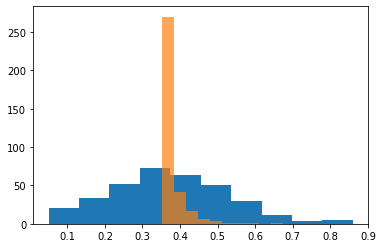

In [169]:
#RF
t=-1
print(geo.columns[t])
plt.hist(real[t])
plt.hist(pred[t],alpha = 0.7)

Oil density


(array([ 26.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   2.,  35., 257.,
         17.,   2.,   0.,   0.,   2.,   0.,   0.,   0.,   1.]),
 array([   0.        ,   82.64640647,  165.29281294,  247.93921941,
         330.58562587,  413.23203234,  495.87843881,  578.52484528,
         661.17125175,  743.81765822,  826.46406469,  909.11047115,
         991.75687762, 1074.40328409, 1157.04969056, 1239.69609703,
        1322.3425035 , 1404.98890997, 1487.63531643, 1570.2817229 ,
        1652.92812937]),
 <BarContainer object of 20 artists>)

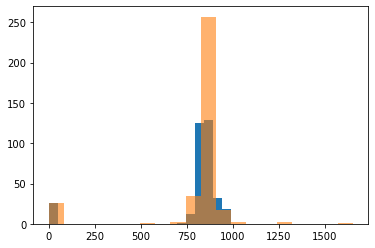

In [164]:
t=-2
print(geo.columns[t])
plt.hist(real[t],bins=20)
plt.hist(pred[t],alpha = 0.6,bins=20)

Depth


(array([  9.,  19.,  95., 162.,  50.,   3.,   1.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([    0.        ,   579.23634551,  1158.47269102,  1737.70903654,
         2316.94538205,  2896.18172756,  3475.41807307,  4054.65441858,
         4633.8907641 ,  5213.12710961,  5792.36345512,  6371.59980063,
         6950.83614614,  7530.07249166,  8109.30883717,  8688.54518268,
         9267.78152819,  9847.0178737 , 10426.25421921, 11005.49056473,
        11584.72691024, 12163.96325575, 12743.19960126, 13322.43594677,
        13901.67229229, 14480.9086378 , 15060.14498331, 15639.38132882,
        16218.61767433, 16797.85401985, 17377.09036536]),
 <BarContainer object of 30 artists>)

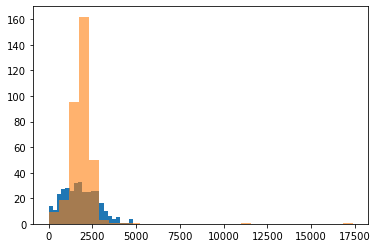

In [166]:
t=-3
print(geo.columns[t])
plt.hist(real[t],bins=20)
plt.hist(pred[t],alpha = 0.6,bins=30)

In [190]:
depth_sorted = sorted(pred[-3])
depth_sorted

[0,
 0,
 0,
 0,
 0,
 76.43797970990272,
 78.35951159683644,
 171.53515217241488,
 479.07788961561437,
 593.3881640249826,
 595.3893282433357,
 671.0945270396445,
 695.2176292753843,
 792.7000000000002,
 815.6986835261658,
 833.5,
 904.2032419502293,
 921.0294580193981,
 926.1220473859823,
 1000.4075686499887,
 1049.0803882215162,
 1064.2734395206426,
 1079.9732698664252,
 1092.3665362156528,
 1136.1323986339864,
 1140.4183118915005,
 1143.4850410309064,
 1152.1169211702868,
 1160.5611302220063,
 1176.5683221207476,
 1189.8676620285867,
 1191.844369190971,
 1208.615176673143,
 1227.1947085347413,
 1237.6959979361234,
 1243.530207054355,
 1255.4510367889934,
 1260.4907205715292,
 1284.9822777568138,
 1290.6198005476535,
 1296.959009045241,
 1299.665502126524,
 1300.869672303176,
 1301.4407773927092,
 1305.4078064874188,
 1309.4667045054666,
 1319.7187163453439,
 1329.3799585504833,
 1355.8005896153727,
 1364.8651734830948,
 1395.2143815890054,
 1395.8316291966692,
 1397.7723901388827,
 1

Permeability


(array([26., 55., 39.,  1.,  1.,  8., 26., 15., 29., 27., 19., 11., 20.,
        14., 13., 11.,  6.,  4.,  5.,  2.,  4.,  4.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  2.]),
 array([   0.        ,   96.16367426,  192.32734853,  288.49102279,
         384.65469706,  480.81837132,  576.98204559,  673.14571985,
         769.30939412,  865.47306838,  961.63674265, 1057.80041691,
        1153.96409118, 1250.12776544, 1346.29143971, 1442.45511397,
        1538.61878824, 1634.7824625 , 1730.94613677, 1827.10981103,
        1923.27348529, 2019.43715956, 2115.60083382, 2211.76450809,
        2307.92818235, 2404.09185662, 2500.25553088, 2596.41920515,
        2692.58287941, 2788.74655368, 2884.91022794]),
 <BarContainer object of 30 artists>)

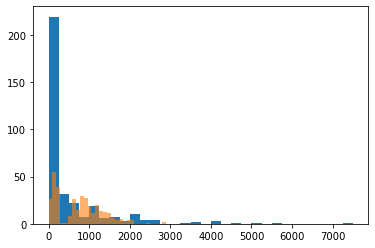

In [171]:
t=-4
print(geo.columns[t])
plt.hist(real[t],bins=30)
plt.hist(pred[t],alpha = 0.6,bins=30)

Porosity


(array([ 1.,  0.,  0.,  5.,  0.,  1.,  0.,  0.,  2., 10., 17., 37., 18.,
        12., 40.,  3.,  1., 90.,  3.,  4.,  0.,  1., 37.,  0.,  3.,  2.,
         0.,  0.,  0., 56.]),
 array([ 8.23216762,  8.82578867,  9.41940973, 10.01303078, 10.60665184,
        11.20027289, 11.79389395, 12.387515  , 12.98113606, 13.57475711,
        14.16837817, 14.76199922, 15.35562028, 15.94924133, 16.54286239,
        17.13648344, 17.7301045 , 18.32372555, 18.91734661, 19.51096766,
        20.10458872, 20.69820977, 21.29183083, 21.88545188, 22.47907294,
        23.07269399, 23.66631505, 24.2599361 , 24.85355716, 25.44717821,
        26.04079927]),
 <BarContainer object of 30 artists>)

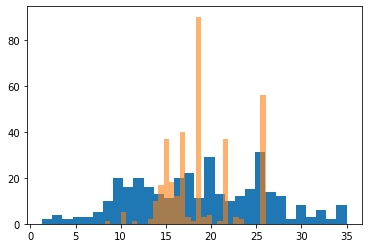

In [176]:
t=-5
print(geo.columns[t])
plt.hist(real[t],bins=30)
plt.hist(pred[t],alpha = 0.6,bins=30)

Netpay


(array([71., 71., 46., 38., 27., 33., 20., 10.,  8.,  9.,  1.,  1.,  3.,
         0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  2.]),
 array([  0.        ,  16.26083602,  32.52167203,  48.78250805,
         65.04334406,  81.30418008,  97.56501609, 113.82585211,
        130.08668812, 146.34752414, 162.60836015, 178.86919617,
        195.13003218, 211.3908682 , 227.65170421, 243.91254023,
        260.17337624, 276.43421226, 292.69504827, 308.95588429,
        325.2167203 , 341.47755632, 357.73839233, 373.99922835,
        390.26006436, 406.52090038, 422.78173639, 439.04257241,
        455.30340842, 471.56424444, 487.82508045]),
 <BarContainer object of 30 artists>)

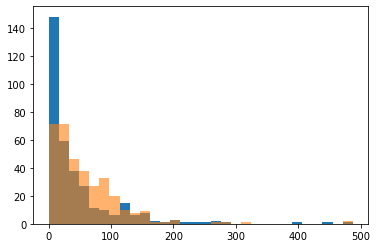

In [177]:
t=-6
print(geo.columns[t])
plt.hist(real[t],bins=30)
plt.hist(pred[t],alpha = 0.6,bins=30)

Gross


(array([216.,  67.,  28.,  15.,   2.,   4.,   2.,   2.,   2.,   0.,   1.,
          0.,   0.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 362.41237906,  438.27063134,  514.12888361,  589.98713589,
         665.84538816,  741.70364043,  817.56189271,  893.42014498,
         969.27839726, 1045.13664953, 1120.9949018 , 1196.85315408,
        1272.71140635, 1348.56965863, 1424.4279109 , 1500.28616317,
        1576.14441545, 1652.00266772, 1727.86092   , 1803.71917227,
        1879.57742454, 1955.43567682, 2031.29392909, 2107.15218137,
        2183.01043364, 2258.86868592, 2334.72693819, 2410.58519046,
        2486.44344274, 2562.30169501, 2638.15994729]),
 <BarContainer object of 30 artists>)

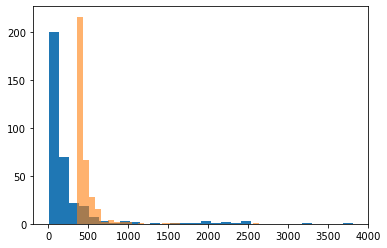

In [178]:
t=-7
print(geo.columns[t])
plt.hist(real[t],bins=30)
plt.hist(pred[t],alpha = 0.6,bins=30)

In [192]:
gross_sorted = sorted(real[-7])
gross_sorted

[3.4,
 6.1,
 8.5,
 9.8,
 10.7,
 12.2,
 12.2,
 13.1,
 13.1,
 13.7,
 14.0,
 14.3,
 14.3,
 14.3,
 15.2,
 15.2,
 15.5,
 15.9,
 17.4,
 17.7,
 18.3,
 18.3,
 19.1,
 19.5,
 19.8,
 20.1,
 20.1,
 20.1,
 21.0,
 21.3,
 21.3,
 21.3,
 21.3,
 22.0,
 22.0,
 22.1,
 22.9,
 22.9,
 22.9,
 24.4,
 24.4,
 24.4,
 24.4,
 25.0,
 25.6,
 25.9,
 27.4,
 27.4,
 29.0,
 29.9,
 30.5,
 30.5,
 30.5,
 30.5,
 30.5,
 30.5,
 30.5,
 30.5,
 30.5,
 30.5,
 30.5,
 30.5,
 30.5,
 32.0,
 33.5,
 33.5,
 34.1,
 35.1,
 35.1,
 35.1,
 35.1,
 35.1,
 35.1,
 36.0,
 36.6,
 36.6,
 36.6,
 36.6,
 36.6,
 36.6,
 36.9,
 37.5,
 39.0,
 39.6,
 39.6,
 41.2,
 41.2,
 42.1,
 42.7,
 42.7,
 43.0,
 43.9,
 44.2,
 44.2,
 44.8,
 45.7,
 45.7,
 45.7,
 48.2,
 50.0,
 50.0,
 50.0,
 50.3,
 50.3,
 53.4,
 54.9,
 54.9,
 56.4,
 57.9,
 57.9,
 61.0,
 61.0,
 61.0,
 61.0,
 61.0,
 61.0,
 64.0,
 64.0,
 64.0,
 66.2,
 67.4,
 70.1,
 70.1,
 70.1,
 70.1,
 70.4,
 71.0,
 71.6,
 72.3,
 73.2,
 75.9,
 76.2,
 76.2,
 76.2,
 76.2,
 76.2,
 76.2,
 78.4,
 79.3,
 79.9,
 82.3,
 83.2,
 83.5,
 83

Structural setting


(array([ 60.,   0.,   0.,   0.,   0., 185.,   0.,   3.,   0.,   0.,   0.,
          0.,  74.,   0.,   0.,   8.,   0.,   0.,   0.,   0.,   8.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   3.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
         4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
         8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. ]),
 <BarContainer object of 30 artists>)

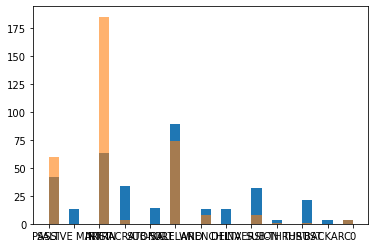

In [179]:
t=-8
print(geo.columns[t])
plt.hist(real[t],bins=30)
plt.hist(pred[t],alpha = 0.6,bins=30)

Lithology


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 343.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([2.5       , 2.53333333, 2.56666667, 2.6       , 2.63333333,
        2.66666667, 2.7       , 2.73333333, 2.76666667, 2.8       ,
        2.83333333, 2.86666667, 2.9       , 2.93333333, 2.96666667,
        3.        , 3.03333333, 3.06666667, 3.1       , 3.13333333,
        3.16666667, 3.2       , 3.23333333, 3.26666667, 3.3       ,
        3.33333333, 3.36666667, 3.4       , 3.43333333, 3.46666667,
        3.5       ]),
 <BarContainer object of 30 artists>)

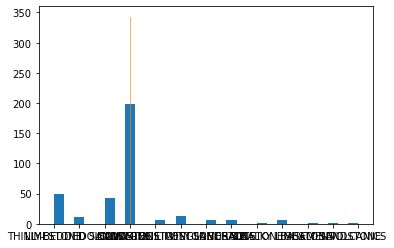

In [180]:
t=-9
print(geo.columns[t])
plt.hist(real[t],bins=30)
plt.hist(pred[t],alpha = 0.6,bins=30)

Period2


(array([27.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9., 10.,  3.,
         6., 18.,  9., 32.,  9., 55., 43., 62., 11.,  9., 25., 11.,  0.,
         0.,  0.,  3.,  1.]),
 array([0.        , 0.24422648, 0.48845297, 0.73267945, 0.97690593,
        1.22113242, 1.4653589 , 1.70958538, 1.95381187, 2.19803835,
        2.44226484, 2.68649132, 2.9307178 , 3.17494429, 3.41917077,
        3.66339725, 3.90762374, 4.15185022, 4.3960767 , 4.64030319,
        4.88452967, 5.12875615, 5.37298264, 5.61720912, 5.86143561,
        6.10566209, 6.34988857, 6.59411506, 6.83834154, 7.08256802,
        7.32679451]),
 <BarContainer object of 30 artists>)

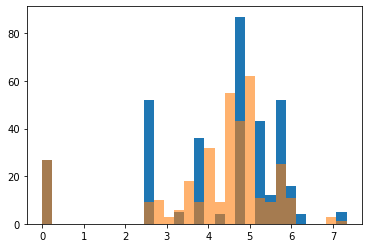

In [183]:
t=-10
print(geo.columns[t])
plt.hist(real[t],bins=30)
plt.hist(pred[t],alpha = 0.6,bins=30)

Tectonic regime


(array([150.,   0.,   0.,   0.,   0.,   0.,   0.,  62.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,  83.,   0.,   0.,   0.,   0.,   0.,   0.,
         15.,   0.,   0.,   0.,   0.,   0.,   0.,  33.]),
 array([0.        , 0.13333333, 0.26666667, 0.4       , 0.53333333,
        0.66666667, 0.8       , 0.93333333, 1.06666667, 1.2       ,
        1.33333333, 1.46666667, 1.6       , 1.73333333, 1.86666667,
        2.        , 2.13333333, 2.26666667, 2.4       , 2.53333333,
        2.66666667, 2.8       , 2.93333333, 3.06666667, 3.2       ,
        3.33333333, 3.46666667, 3.6       , 3.73333333, 3.86666667,
        4.        ]),
 <BarContainer object of 30 artists>)

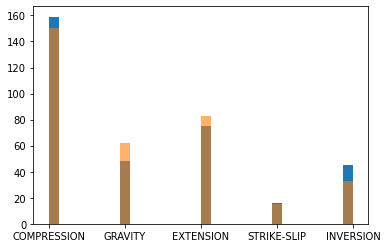

In [184]:
t=-11
print(geo.columns[t])
plt.hist(real[t],bins=30)
plt.hist(pred[t],alpha = 0.6,bins=30)